# Implementing Flat Tax Rate
We will be looking at what people actually pay, what they should pay, and how to decrease to a flat tax rate. \
Evan Sellers + Michael Yager

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv("./data/tax_data_2020.csv")
df = df[df.zipcode != 0]

In [3]:
def toMillion(amount):
    return round(amount / 1000000, 2)

def toBillion(amount):
    return round(amount / 1000000000, 2)

def toTrillion(amount):
    return round(amount / 1000000000000, 10)

## Percentage of Income Tax - Paided

In [4]:
# Remove Rows w/ Zero Income
df = df[df["A02650"] != 0]

In [5]:
df["taxPercentagePaid"] = df.apply(lambda row: row["A06500"] / row["A00100"], axis=1)

In [6]:
paid = df.groupby(["agi_stub"])["taxPercentagePaid"].mean()
paid

agi_stub
1    0.012746
2    0.044214
3    0.065613
4    0.078532
5    0.110051
6    0.188869
Name: taxPercentagePaid, dtype: float64

## Percentage of Income Tax - Expected

### Returns

In [7]:
df["taxPercentageReturn"] = df.apply(lambda row: 1 - (row["A00100"] / row["A02650"]), axis=1)

In [8]:
returns = df.groupby(["agi_stub"])["taxPercentageReturn"].mean()
returns

agi_stub
1    0.019301
2    0.012092
3    0.011414
4    0.009370
5    0.010816
6    0.010638
Name: taxPercentageReturn, dtype: float64

### Credits

In [9]:
TAX_CREDIT_AMT_1040  = [ "A07225", "A11070", "A10960", "A10970" ]
TAX_CREDIT_AMT_SCH3  = [ "A07230", "A07240", "A07180", "A07300", "A07260", "A09400", "A11450", "A11560" ]

In [10]:
def sumColumns(dataframe, columns):
    total = 0
    for col in columns:
        total += abs(dataframe[col])
    return total

In [11]:
df["credits"] = df.apply(lambda row: (sumColumns(row, TAX_CREDIT_AMT_SCH3) + sumColumns(row, TAX_CREDIT_AMT_1040)), axis=1)

In [12]:
df["taxPercentageCredit"] = df.apply(lambda row: row["credits"] / row["A02650"], axis=1)

In [13]:
df.groupby(["agi_stub"])["credits"].sum()

agi_stub
1    46161900.0
2    54919370.0
3    34827480.0
4    25014840.0
5    52657448.0
6    41222786.0
Name: credits, dtype: float64

In [14]:
credits = df.groupby(["agi_stub"])["taxPercentageCredit"].mean()
credits

agi_stub
1    0.065316
2    0.036898
3    0.025105
4    0.019558
5    0.014639
6    0.005525
Name: taxPercentageCredit, dtype: float64

This is intresting. This means lower income brackets take advantage of tax credits, and they are a larger impact to their overall taxes.

### Total

In [15]:
expected = paid + returns + credits
expected

agi_stub
1    0.097362
2    0.093203
3    0.102132
4    0.107461
5    0.135507
6    0.205032
dtype: float64

## Flat Tax Rate Basic
According to the congress report we have to account for `$1,609 Billion` in revenue for income taxes. \
[Revenues in Fiscal Year 2020](https://www.cbo.gov/system/files/2020-11/56746-MBR.pdf)

In [17]:
# Amount to acheive - reported by congress
print("$", toBillion(df["A02650"].sum()*1000), "Billion")

$ 12811.09 Billion


In [18]:
# Percent each citizen must pay
1609/toBillion(df["A02650"].sum()*1000)

0.12559430930545332

This number mean that most citizens must pay around `15%`, this is an issue though because this means most citizens are pay more than they currently are paying.

In [19]:
expected - paid

agi_stub
1    0.084617
2    0.048989
3    0.036520
4    0.028928
5    0.025455
6    0.016163
dtype: float64

This means according to the tax bracket that poorer individules are not paying their fair share according to the tax bracket.

## Flat Tax Rate Complexity
The issue is tax rate is not this simple. Because the tax brackets are progressive. So we must set a minimum that is taxed and a rate. 

In [20]:
df["rate"] = df.apply(lambda row: row["A06500"] / row["A00100"], axis=1)
PAID_RATE  = df.groupby("agi_stub")["rate"].mean()

In [21]:
def taxSystemRevenue(dataframe, minTaxable, rate):
    df["taxed"] = df.apply(lambda row: max((row["A02650"] - (row["N1"] * minTaxable)), 0) * rate, axis=1)
    taxed       = df.groupby("agi_stub")["taxed"].sum()
    income      = df.groupby("agi_stub")["A02650"].sum()
    rate        = (taxed/income).round(4)
    return rate, taxed.sum()

In [22]:
WEIGHTS = [2**6, 2**5, 2**4, 2**3, 2**2, 2]

def scoreTaxSystemRevenue(rate, revenue):
    if toBillion(revenue * 1000) < 1609:
        return 100
    diff  = rate - PAID_RATE
    wdiff = diff * WEIGHTS
    return wdiff.sum() + toBillion(revenue * 1000) - 1609

In [23]:
def simulateTaxSystemRevenue(dataframe, minTaxable, rate):
    rate, revenue = taxSystemRevenue(dataframe, minTaxable, rate)
    return scoreTaxSystemRevenue(rate, revenue)

### Search Grid

In [26]:
MIN_TAXABLE = list(range(0,100, 5))                                 # $0 - $100,000 by 5000s
TAX_RATE    = list(map(lambda x: round(x * 0.01, 2), range(1, 31))) # 0.01% - 0.30% by 0.01

### Perform Search

In [27]:
cols = list(map(lambda x: str(x) + "%", TAX_RATE))
rows = list(map(lambda x: "$" + "{:,}".format(x * 1000), MIN_TAXABLE))
grid = pd.DataFrame(columns=cols, index=rows)

In [ ]:
total = len(TAX_RATE) * len(MIN_TAXABLE)
done  = 0

for indexTaxRate in range(len(TAX_RATE)):
    results = []
    for indexMinTax in range(len(MIN_TAXABLE)):
        taxRate = TAX_RATE[indexTaxRate]
        minTax  = MIN_TAXABLE[indexMinTax]
        results.append(simulateTaxSystemRevenue(df, minTax, taxRate))
        done += 1
        print('\r' + str(done) + " of " + str(total), end="\r")
    grid[grid.columns[indexTaxRate]] = results

In [387]:
grid

,0.01%,0.02%,0.03%,0.04%,0.05%,0.06%,0.07%,0.08%,0.09%,0.1%,...,0.21%,0.22%,0.23%,0.24%,0.25%,0.26%,0.27%,0.28%,0.29%,0.3%
$0,100,100,100,100,100,100,100,100,100,100,...,21.73343,22.99343,24.25343,25.51343,26.77343,28.03343,29.29343,30.55343,31.81343,33.07343
"$5,000",100,100,100,100,100,100,100,100,100,100,...,15.07363,16.01703,16.96403,17.90703,18.84723,19.78703,20.73723,21.67743,22.61883,23.55983
"$10,000",100,100,100,100,100,100,100,100,100,100,...,8.42323,9.05363,9.67363,10.30243,10.93183,11.55583,12.18543,12.80623,13.43623,14.05943
"$15,000",100,100,100,100,100,100,100,100,100,100,...,4.34903,4.78123,5.21143,5.64643,6.07743,6.50943,6.94123,7.37303,7.80683,8.23883
"$20,000",100,100,100,100,100,100,100,100,100,100,...,3.03303,3.40263,3.77403,4.14163,4.51283,4.88143,5.25103,5.62183,5.98983,6.36083
"$25,000",100,100,100,100,100,100,100,100,100,100,...,1.72083,2.02623,2.33363,2.64083,2.94703,3.25403,3.56123,3.86903,4.17443,4.48243
"$30,000",100,100,100,100,100,100,100,100,100,100,...,0.40323,0.65023,0.89303,1.13543,1.38243,1.62523,1.87263,2.11463,2.35843,2.60483
"$35,000",100,100,100,100,100,100,100,100,100,100,...,-0.90937,-0.72637,-0.54357,-0.36537,-0.18217,0.00043,0.18203,0.36503,0.54343,0.72603
"$40,000",100,100,100,100,100,100,100,100,100,100,...,-1.63337,-1.48557,-1.33957,-1.19097,-1.04337,-0.89717,-0.74817,-0.60217,-0.45437,-0.30837
"$45,000",100,100,100,100,100,100,100,100,100,100,...,100.00000,-1.90537,-1.77777,-1.64817,-1.52157,-1.39197,-1.26517,-1.13617,-1.00897,-0.87977


<AxesSubplot: >

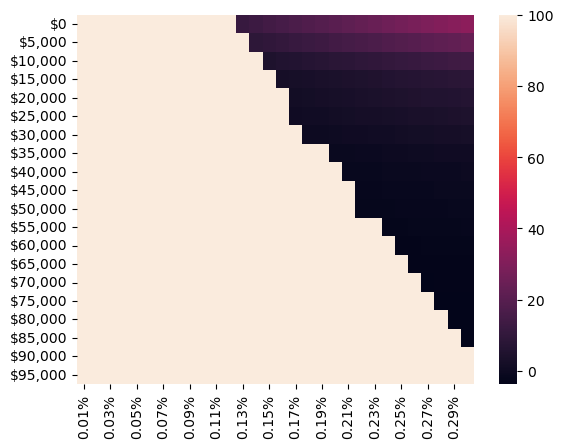

In [386]:
sns.heatmap(grid)

## Deeper Comparison of Best Results
Breakdown the top results to see which system is the best for each tax bracket.

In [539]:
taxRate           = grid.min(axis=0)[12:].reset_index()
minTax            = grid.min(axis=1)[:-2].reset_index()
taxRate.columns   = ["Tax Rate", "Score"]
minTax.columns    = ["Min Taxable", "_"]
breakdown         = taxRate.join(minTax).drop("_", axis=1)

In [540]:
breakdown

,Tax Rate,Score,Min Taxable
0,0.13%,11.65343,$0
1,0.14%,8.47283,"$5,000"
2,0.15%,4.66623,"$10,000"
3,0.16%,2.18723,"$15,000"
4,0.17%,0.49243,"$20,000"
5,0.18%,-0.32897,"$25,000"
6,0.19%,-0.08617,"$30,000"
7,0.2%,-1.09097,"$35,000"
8,0.21%,-1.63337,"$40,000"
9,0.22%,-2.32457,"$45,000"


In [572]:
results = [[], [], [], [], [], [], [], [], [], [], [], [], []]
total = len(breakdown)
done  = 0

for index in range(len(breakdown)):
    minTax  = int(breakdown.iloc[index]["Min Taxable"].replace(",", "").replace("$", ""))/1000
    taxRate = float(breakdown.iloc[index]["Tax Rate"].replace("%", ""))
    rate, revenue = taxSystemRevenue(df, minTax, taxRate)
    diff          = rate - PAID_RATE
    results[0].append("$" + str(round(toBillion(revenue * 1000), 0)))
    results[1].append(rate.iloc[0])
    results[2].append(rate.iloc[1])
    results[3].append(rate.iloc[2])
    results[4].append(rate.iloc[3])
    results[5].append(rate.iloc[4])
    results[6].append(rate.iloc[5])
    results[7].append(diff.iloc[0])
    results[8].append(diff.iloc[1])
    results[9].append(diff.iloc[2])
    results[10].append(diff.iloc[3])
    results[11].append(diff.iloc[4])
    results[12].append(diff.iloc[5])
    done += 1
    print('\r' + str(done) + " of " + str(total), end="\r")
breakdown["Revenue"] = results[0]
breakdown["Tax 1"]  = results[1]
breakdown["Tax 2"]  = results[2]
breakdown["Tax 3"]  = results[3]
breakdown["Tax 4"]  = results[4]
breakdown["Tax 5"]  = results[5]
breakdown["Tax 6"]  = results[6]
breakdown["Diff 1"]  = results[7]
breakdown["Diff 2"]  = results[8]
breakdown["Diff 3"]  = results[9]
breakdown["Diff 4"]  = results[10]
breakdown["Diff 5"]  = results[11]
breakdown["Diff 6"]  = results[12]

In [571]:
breakdown

,Tax Rate,Score,Min Taxable,Revenue,Diff 1,Diff 2,Diff 3,Diff 4,Diff 5,Diff 6,Tax 1,Tax 2,Tax 3,Tax 4,Tax 5,Tax 6
0,0.13%,11.65343,$0,$1665.0,0.117254,0.085786,0.064387,0.051468,0.019949,-0.058869,0.1300,0.1300,0.1300,0.1300,0.1300,0.1300
1,0.14%,8.47283,"$5,000",$1683.0,0.071554,0.076786,0.063087,0.053468,0.024849,-0.050169,0.0843,0.1210,0.1287,0.1320,0.1349,0.1387
2,0.15%,4.66623,"$10,000",$1685.0,0.018054,0.064986,0.060187,0.054368,0.029149,-0.041669,0.0308,0.1092,0.1258,0.1329,0.1392,0.1472
3,0.16%,2.18723,"$15,000",$1690.0,-0.012746,0.050486,0.055687,0.054068,0.032649,-0.033369,0.0000,0.0947,0.1213,0.1326,0.1427,0.1555
4,0.17%,0.49243,"$20,000",$1705.0,-0.012746,0.033286,0.049587,0.052568,0.035349,-0.025169,0.0000,0.0775,0.1152,0.1311,0.1454,0.1637
5,0.18%,-0.32897,"$25,000",$1708.0,-0.012746,0.013386,0.041887,0.050068,0.037449,-0.017169,0.0000,0.0576,0.1075,0.1286,0.1475,0.1717
6,0.19%,-0.08617,"$30,000",$1701.0,-0.012746,-0.009314,0.032587,0.046268,0.038749,-0.009469,0.0000,0.0349,0.0982,0.1248,0.1488,0.1794
7,0.2%,-1.09097,"$35,000",$1683.0,-0.012746,-0.034614,0.021687,0.041468,0.039349,-0.001869,0.0000,0.0096,0.0873,0.1200,0.1494,0.1870
8,0.21%,-1.63337,"$40,000",$1681.0,-0.012746,-0.044214,0.009087,0.035468,0.039249,0.005531,0.0000,0.0000,0.0747,0.1140,0.1493,0.1944
9,0.22%,-2.32457,"$45,000",$1685.0,-0.012746,-0.044214,-0.005013,0.028268,0.038449,0.012731,0.0000,0.0000,0.0606,0.1068,0.1485,0.2016


In [566]:
taxSystemRevenue(df, 85, 0.1)

(agi_stub
 1    0.0000
 2    0.0000
 3    0.0000
 4    0.0029
 5    0.0386
 6    0.0842
 dtype: float64,
 agi_stub
 1    0.000000e+00
 2    0.000000e+00
 3    2.700501e+03
 4    3.610853e+06
 5    1.194647e+08
 6    4.207985e+08
 Name: taxed, dtype: float64)

In [569]:
taxSystemRevenue(df, 85, 0.3)

(agi_stub
 1    0.0000
 2    0.0000
 3    0.0000
 4    0.0087
 5    0.1157
 6    0.2527
 dtype: float64,
 1631630304.47421)